# Classification using machine learning SVC, RandomForest, and GBDT 
---
*For training machine learning models for user interface* 

Files with different formats, such as excel, txt, json, csv, can be imported from local computer or cloud <br> 
The imported data can be labelled, pre-treated, scaled for further analysis <br>
The visualization of data is interactive. Different features and ranges of data points can be selectively visualized<br>
However, this cannot be shown in html file  

**Dummy data used in this file. Data sets with more features and data points are used in our real analyses**
**Parameters can be optimized using GridSearchCV or other techniques. The model is not optimized in this file becanse of limited data used.**

[Labjournal](https://lipidknowledge-my.sharepoint.com/ 'labjournal')    


    

In [2]:
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import Button
from tkinter import filedialog, Tk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
from datetime import datetime


import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import tree

In [3]:
print(f'Analysis on data on {datetime.now().date():%d-%m-%Y}')

Analysis on data on 01-07-2022


# Modules used in this report

In [4]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            ver = getattr(val, '__version__', 'N.A.')
            name = val.__name__
            print(f'{name}=={ver}') 
imports()

builtins==N.A.
builtins==N.A.
ipywidgets==7.6.5
tkinter.filedialog==N.A.
pandas==1.3.4
numpy==1.20.3
matplotlib.pyplot==N.A.
seaborn==0.11.2
itertools==N.A.
pickle==N.A.
sklearn==0.24.2
sklearn.tree==N.A.
types==N.A.


# Import data to Pandas dataframe

In [5]:
def import_data(path, sheet_name=None, skiprows=0, index_col=[],usecols=None, nrows=0):
    df = pd.read_excel(path, sheet_name=sheet_name, skiprows=skiprows, 
                       index_col=index_col, usecols=usecols,nrows=nrows)
    return df

In [6]:
sheet_name = input('Which sheet to import?  ')
number_of_rows = int(input('How many rows to import?  '))
skiprows = int(input('Skip how many rows?  '))
use_columns = ['NO.','Ag1', 'Ag2','Ag3', 'Ag4']

Which sheet to import?  Results
How many rows to import?  148
Skip how many rows?  3


In [7]:
fileselect = Button(description="Select File")
root=Tk()

def select_file(b):
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    file = filedialog.askopenfilename(multiple=True)
    root.update()
    select_file.data=import_data(path=file[0], sheet_name=sheet_name, skiprows=skiprows,
            index_col=0, usecols=use_columns, nrows=number_of_rows)
    print(f'"{file[0]}" was selected')
    root.destroy()

fileselect.on_click(select_file)
display(fileselect)

Button(description='Select File', style=ButtonStyle())

"C:/Users/KE-Instruments/Desktop/code/SOFTWARE/for_general/0623_general.xlsx" was selected


In [8]:
df = select_file.data

In [9]:
@interact
def show_articles_more_than(column=['Ag1', 'Ag2','Ag3', 'Ag4'], x=(0,2,0.1)):
    return df.loc[df[column] > x]

interactive(children=(Dropdown(description='column', options=('Ag1', 'Ag2', 'Ag3', 'Ag4'), value='Ag1'), Float…

In [10]:
df2 = df.copy()
df2['label'] = 0
df2['label'].iloc[112:] = 1
df2.reset_index(drop=False, inplace=True)
df2.style.background_gradient(axis=0)  

C:\Users\KE-Instruments\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,NO.,Ag1,Ag2,Ag3,Ag4,label
0,16,1.267091,0.763889,1.372449,1.130435,0
1,17,1.053405,0.668435,1.077519,1.063636,0
2,18,1.413902,0.755639,0.969072,0.929825,0
3,19,0.903633,0.988722,0.690722,0.929825,0
4,20,1.416534,1.107639,1.387755,1.141304,0
5,23,0.954617,0.570513,0.778302,1.227273,0
6,24,1.079812,0.689103,0.877358,1.545455,0
7,25,0.668232,0.528846,0.693396,1.000000,0
8,26,0.928013,0.615385,0.787736,0.988636,0
9,27,1.511737,0.618590,1.028302,1.272727,0


**Table 1** Features and labels. Patient samples are labelled 1. Health samples are labelled 0.

In [11]:
df2['label'].value_counts()

0    112
1     36
Name: label, dtype: int64

# Data visualization

In [12]:
df2.iloc[:,0:-1].describe()

,NO.,Ag1,Ag2,Ag3,Ag4
count,148.000000,148.000000,148.000000,148.000000,148.000000
mean,2916.851351,1.247777,0.973597,1.163569,1.072519
std,2930.266059,0.459154,0.530195,0.648751,0.391609
min,16.000000,0.153938,0.316364,0.178322,0.455056
25%,922.750000,0.931014,0.656561,0.749175,0.802679
50%,1242.500000,1.171263,0.870064,0.942736,0.957471
75%,5013.250000,1.544866,1.083873,1.376276,1.214713
max,12472.000000,2.621019,4.021818,3.945312,2.587156


**Table 2** Overview of the 4 antigens. Feature with higher std is normally preferred by algorithms.

In [13]:
@interact
def plot_drop(x=list(df2.columns[1:-1]),y=list(df2.columns[2:-1]),theme=[ 'scatter', 'hist', 'hex', 'kde', 'reg', 'resid']):

    sns.jointplot(data=df2, x=x, y=y, kind=theme)

interactive(children=(Dropdown(description='x', options=('Ag1', 'Ag2', 'Ag3', 'Ag4'), value='Ag1'), Dropdown(d…

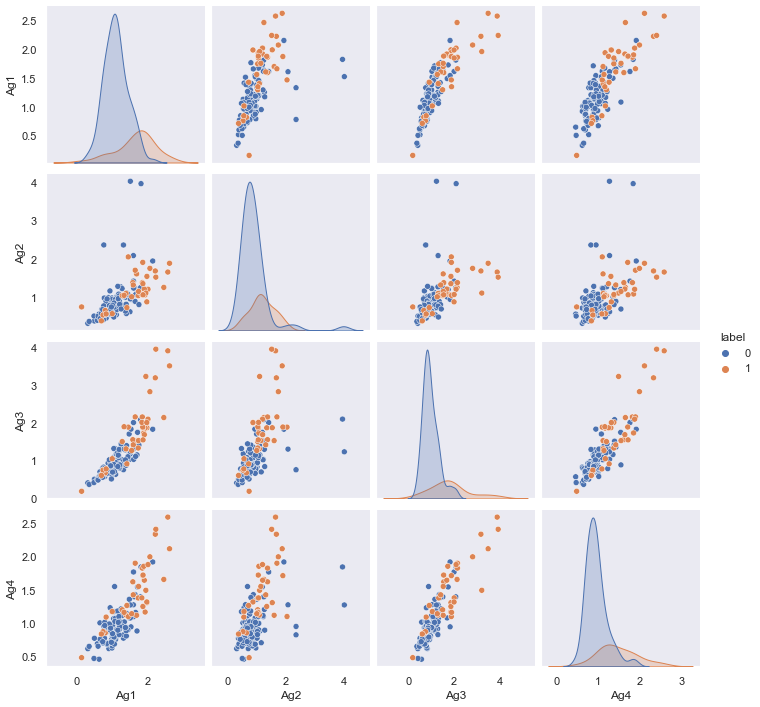

In [19]:
sns.set_theme(style="dark")
sns.pairplot(df2.iloc[:, 1:], hue='label')
# plt.savefig('sns.png', dpi=300)

**Figure 1** The distribution of antigen and its correlation with other antigens. The feature dimensions need to be reduced if some features are showing good correlations.

# Support-vector machine as classifier

In [14]:
X = df2.iloc[:,1:-1]
y = df2['label']

In [15]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=0)

clf = SVC(kernel = "poly",C=3,class_weight={1:3}).fit(Xtrain,Ytrain) 

clf.score(Xtest, Ytest), clf.score(Xtrain,Ytrain)

(0.8222222222222222, 0.8543689320388349)

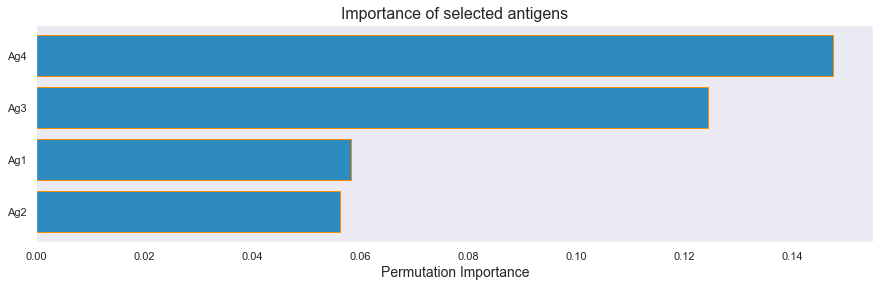

In [22]:
def importance_of_feature(estimator, X, y, feature_names=None):
    perm_importance = permutation_importance(estimator, X, y)

    features = np.array(feature_names)

    sorted_idx = perm_importance.importances_mean.argsort()
    fig, ax = plt.subplots(figsize=(15,4))
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], color='#2E8BC0',edgecolor='darkorange')
    plt.xlabel("Permutation Importance",fontsize=14)
    ax.set_title('Importance of selected antigens', fontsize=16)
    
feature_names = df2.columns[1:]
importance_of_feature(clf, Xtrain, Ytrain, feature_names=feature_names)

**Figure 2** Feature importance. It shows how important the feature is in building the specific model. 

In [23]:
# Calculate the scores of different combination of antigens

item = list(df2.columns[1:-1])
antigen = []
score_test = []
score_train = []
for m in range(4): 
    for r in itertools.combinations(item, m+1):
        Xtrain,Xtest,Ytrain,Ytest = train_test_split(X.loc[:,r],y,test_size=0.3,random_state=2)
        clf = SVC(kernel = "poly",C=0.1,class_weight={1:2}).fit(Xtrain,Ytrain) 
        score1 = clf.score(Xtest, Ytest)
        score2 = clf.score(Xtrain, Ytrain)
        antigen.append(r)
        score_test.append(score1)
        score_train.append(score2)


results_frame = pd.concat([pd.DataFrame(antigen),pd.DataFrame(score_test),pd.DataFrame(score_train)],axis=1, 
          keys=['antigen','score_test','score_train'],levels=None, names=None)
results_frame['score_total'] = results_frame['score_test'] + results_frame['score_train']
results_frame = results_frame.fillna(' ')
results_frame.sort_values(by=['score_total'], ascending=False).head(10)

antigen                score_test score_train score_total
         0    1    2    3          0           0            
10     Ag1  Ag2  Ag3        0.933333    0.854369    1.787702
14     Ag1  Ag2  Ag3  Ag4   0.911111    0.864078    1.775189
11     Ag1  Ag2  Ag4        0.911111    0.854369    1.765480
13     Ag2  Ag3  Ag4        0.888889    0.854369    1.743258
6      Ag1  Ag4             0.888889    0.834951    1.723840
5      Ag1  Ag3             0.866667    0.854369    1.721036
7      Ag2  Ag3             0.866667    0.854369    1.721036
12     Ag1  Ag3  Ag4        0.866667    0.844660    1.711327
2      Ag3                  0.866667    0.834951    1.701618
4      Ag1  Ag2             0.866667    0.834951    1.701618

**Table 3** Model score on test and train datasets with different combinations of features.

Highest score: 0.8640776699029126,
The value of gamma_range: 0.33598182862837817


Text(0, 0.5, 'Model_score')

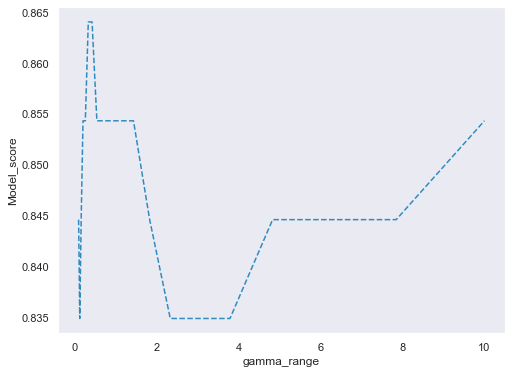

In [24]:
# parameter optimizition

score=[]
gamma_range = np.logspace(-1,1,20)
for i in gamma_range:
    clf = SVC(kernel = 'poly',gamma = i, C=0.1,class_weight={1:2}).fit(Xtrain,Ytrain)
    score.append(clf.score(Xtrain,Ytrain))
print(f'Highest score: {max(score)},\nThe value of gamma_range: {gamma_range[score.index(max(score))]}')
fig, ax=plt.subplots(figsize=(8,6))
plt.plot(gamma_range,score, color='#2E8BC0',linestyle='--')
plt.xlabel('gamma_range')
plt.ylabel('Model_score')

**Figure 3** Influence of one parameter on the model performance. This can only be done when enough samples are tested. More parameters can be optimized using GridSearchCV or others. The generalization of the model can be evaluated from the performance of model on train dataset and test dataset.

In [25]:
y_pre = clf.predict(Xtest)

In [26]:
# Define a function for calculating sensitivity and specificity

def sens_speci_cal(y_test, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp /(tp + fn)
    print(f'The sensitivity is {sensitivity:.2%}, the specificity is {specificity:.2%}')

In [27]:
sens_speci_cal(Ytest, y_pre)

The sensitivity is 66.67%, the specificity is 93.94%


# Random Forest as ensemble classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_validate, KFold

In [29]:
reg_f = RFC(n_estimators=20)
cv = KFold(n_splits = 10, shuffle=True, random_state=88)

In [30]:
result_f = cross_validate(reg_f,
                         X,y,
                         cv=cv,
                         scoring='accuracy',
                         return_train_score=True,
                         verbose=True,
                         n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.8s finished


In [31]:
result_f['train_score'].mean().round(3), result_f['test_score'].mean().round(3)

(0.993, 0.819)

In [32]:
result_f['test_score'].std().round(3)

0.058

In [33]:
reg_f.fit(X,y)

RandomForestClassifier(n_estimators=20)

In [34]:

for i in range(20):
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=i)
    y_pre = reg_f.predict(Xtest)
    sens_speci_cal(Ytest, y_pre)
   

The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 90.91%, the specificity is 100.00%
The sensitivity is 91.67%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 92.86%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivity is 100.00%, the specificity is 100.00%
The sensitivi

In [35]:
sens_speci_cal(Ytest, y_pre)

The sensitivity is 100.00%, the specificity is 100.00%


In [36]:
reg_f.feature_importances_

array([0.26894078, 0.1539699 , 0.39765589, 0.17943343])

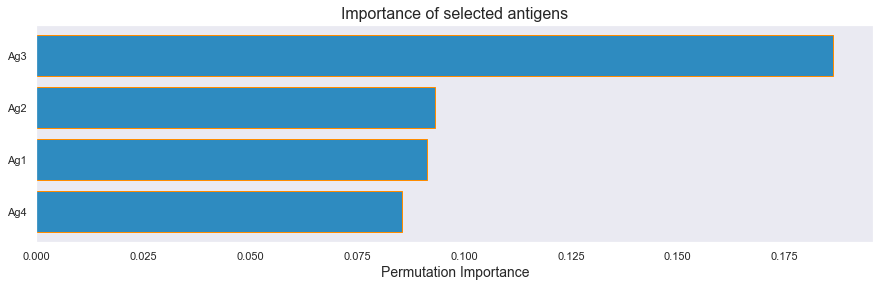

In [37]:
featurenames = df2.columns
importance_of_feature(reg_f, Xtrain, Ytrain, feature_names=feature_names)

**Figure 4** Feature importance in RandomForest model.

[Text(552.1875, 645.525, 'X[1] <= 1.007\ngini = 0.368\nsamples = 93\nvalue = [112, 36]'),
 Text(406.875, 577.575, 'X[1] <= 0.735\ngini = 0.149\nsamples = 59\nvalue = [91, 8]'),
 Text(348.75, 509.625, 'X[3] <= 1.169\ngini = 0.269\nsamples = 30\nvalue = [42, 8]'),
 Text(232.5, 441.67499999999995, 'X[2] <= 0.703\ngini = 0.136\nsamples = 25\nvalue = [38, 3]'),
 Text(174.375, 373.72499999999997, 'X[2] <= 0.651\ngini = 0.236\nsamples = 13\nvalue = [19, 3]'),
 Text(116.25, 305.775, 'X[2] <= 0.596\ngini = 0.095\nsamples = 12\nvalue = [19, 1]'),
 Text(58.125, 237.825, 'gini = 0.0\nsamples = 8\nvalue = [16, 0]'),
 Text(174.375, 237.825, 'X[3] <= 0.833\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(116.25, 169.875, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(232.5, 169.875, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(232.5, 305.775, 'gini = 0.0\nsamples = 1\nvalue = [0, 2]'),
 Text(290.625, 373.72499999999997, 'gini = 0.0\nsamples = 12\nvalue = [19, 0]'),
 Text(465.0, 441.6749999

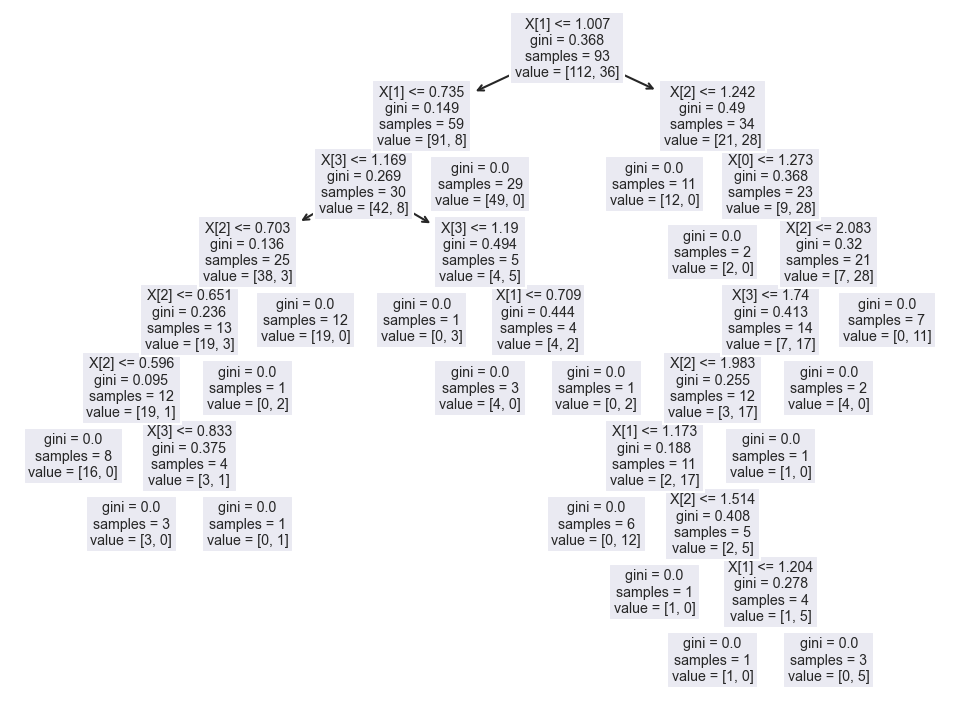

In [38]:
plt.figure(figsize=(8,6), dpi=150)
tree.plot_tree(reg_f.estimators_[1])

**Figure 4** One estimator (Decision Tree) of the 20 estimators used by the algorithm. Gini shows the impurity of the samples in the leaf.

# GBDT as ensemble classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier as GBC 

In [40]:
gbc = GBC(init=reg_f) 
# None or other trained models can also be used as init model.
# Other parameters, such as loss function,parameters for decision tree, can be optimized.

gbc.fit(Xtrain, Ytrain)

gbc.score(Xtest, Ytest).round(3),gbc.score(Xtrain, Ytrain).round(3)

(0.889, 1.0)

In [41]:
cv = KFold(n_splits = 6, shuffle=True, random_state=1412)

result_g = cross_validate(gbc,
                         X,y,
                         cv=cv,
                         scoring='accuracy',
                         return_train_score=True,
                         verbose=True,
                         n_jobs=4)

result_g['train_score'].mean().round(3), result_g['test_score'].mean().round(3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.2s finished


(1.0, 0.771)

In [42]:
sens = []
spec = []
def sens_speci_cal_2(y_test, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp /(tp + fn)
    sens.append(sensitivity)
    spec.append(specificity)
    return sens, spec


for i in range(20):
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=i)
    y_pre = gbc.predict(Xtest)
    sens_speci_cal_2(Ytest, y_pre)

In [43]:
np.array(sens).mean(), np.array(sens).std(), np.array(spec).mean(),np.array(spec).std()

(0.9286538461538463,
 0.08003806203426185,
 0.9728693255481244,
 0.0259590814557017)

<mark> The average sensitivity of 20 random data splits is 0.929 with std 0.08. The specificity is 0.973 with std 0.026. 

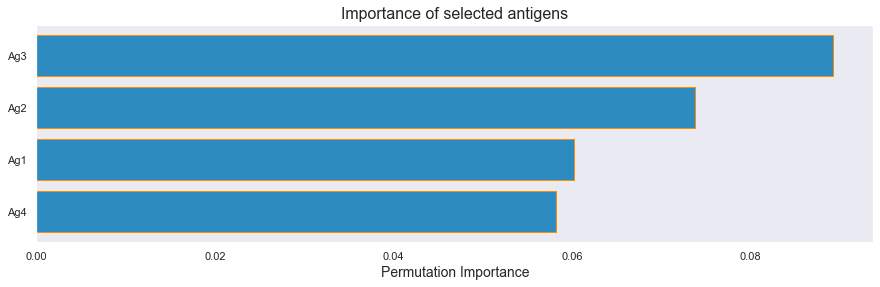

In [44]:
importance_of_feature(gbc, Xtrain, Ytrain, feature_names=feature_names)

**Figure 5** Feature importance in GBDT model.

In [47]:
# save trained models

with open('GBDT_model_general.pkl','wb') as f:
    pickle.dump(gbc,f)


In [48]:
with open('RF_model_general.pkl','wb') as f:
    pickle.dump(reg_f,f)